We will explore the utility of CNNs on this dataset. We will first apply standard data augmentation techniques to then train our model. Based on the results, we will further refine our data. In the second model, the refined data will be used. Next, we will use information about the bounding boxes to further optimize our model. In the end, we will utilize 2 pre-trained models (YOLO and X), to see their benefits regarding this application and dataset.


1. Exploring the data
2. Basic Pre-processing
3. Training a multilabel CNN
4. Refining the data (further augmentation by flipping etc.)
5. Retraining the model
6. Integrating the bounding boxes in the classification (e.g. cropping the image or using other architecture)
7. Training the new model based on that
8. Transfer learning of Yolo and another state-of-the-art model
9. Evaluation, discussion and reflexion

### Stride could be increased to decrease model complexity. 

# EDA - Inspecting images

In [23]:
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import keras.utils as image
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


Let uns inspect the images to see if there are any weird things going on. But before we start, we must clarify that our dataset consists of 3 splits: training, validation and testing. Each image is labeled. The label is in the other subfolder of the dataset split.
The first element in the file is the class type. 0 refers to bad weld, 1 to good weld and 2 to defect. The rest of the elements is the bounding box of the respective class 

#### Text in the images

Some images have text. This is either the source of the video or an explanation about what can be seen in the image. Sometimes the text is smaller, sometimes bigger. In the following we can see that the left image has text that spans over about a third of the image. On the right image, in bottom-right hand side we can see a small text logo.

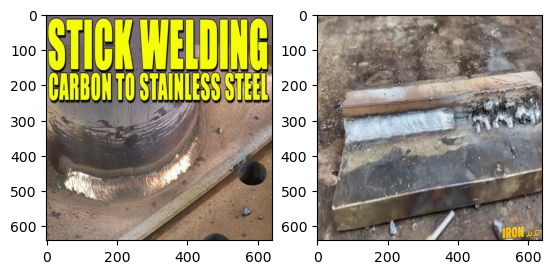

In [24]:
path_text_example1 = "train/images/carbon-steel-good-welds_14_jpeg_jpg.rf.49688b4d08c60bf6a65cc6f03e7d25ff.jpg"
img_text_example1 = Image.open(path_text_example1)

image_datas = []
image_datas.append(img_text_example1)

path_text_example2 = "train/images/bad_weld_vid282_jpeg_jpg.rf.f1ab7871565d470f35111fcf0bcee841.jpg"
img_text_example2 = Image.open(path_text_example2)
image_datas.append(img_text_example2)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_datas[0])
axarr[1].imshow(image_datas[1])

#### Mixture of pre-processed on non-processed images

There are also plenty of images that seem to have been pre-processed. They are rotated, brightness (or contrast) is adjusted and noise has been added. Sifting through the file name it seems that the pre-processed images have '-' and not 'jpeg' in their name.

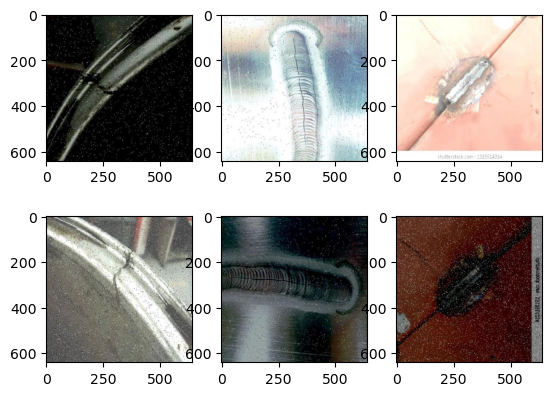

In [25]:
path_pre_list = ["train/images/0e538f39-1d30436c-c23_jpg.rf.9af91763a613bf193d03c39400da2ec6.jpg", "train/images/0e538f39-1d30436c-c23_jpg.rf.05ff78024b481ae4fada24ef439ebd97.jpg","train/images/4d02e003-793c44d4-DWAi7_eXcAAdxuF_jpg.rf.1ed5c14711c779c7eeaba2af500c9167.jpg","train/images/4d02e003-793c44d4-DWAi7_eXcAAdxuF_jpg.rf.2363b9baae3cd601d7c6270f9141ff80.jpg","train/images/53b5de7a-77e2178f-weld-cracking-centerline-longitudinal-crack-260nw-1313514314_jpg.rf.ce6ebf49b78fbe150d2bf182d5b57549.jpg","train/images/53b5de7a-77e2178f-weld-cracking-centerline-longitudinal-crack-260nw-1313514314_jpg.rf.4a55fb16105c903fb111559a7fae1d35.jpg"]
f, axarr = plt.subplots(2,3)
img_pre_list = []

for path in path_pre_list:
    img_pre_list.append(Image.open(path))

axarr[0,0].imshow(img_pre_list[0])
axarr[1,0].imshow(img_pre_list[1])
axarr[0,1].imshow(img_pre_list[2])
axarr[1,1].imshow(img_pre_list[3])
axarr[0,2].imshow(img_pre_list[4])
axarr[1,2].imshow(img_pre_list[5])

#### Unsharp images

Usually the images are sharp/focussed on the weld, but sometimes they aren’t.

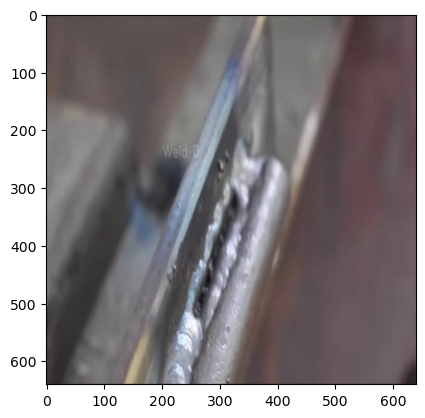

In [26]:
path_unsharp = "train/images/bad_weld_vid560_jpeg_jpg.rf.be4be408da41d602b8c9a7801a7be733.jpg"
img_unsharp = Image.open(path_unsharp)
plt.imshow(img_unsharp)

As we could partly see in the images shown in this notebook, there are plenty of different angles in the dataset that resemble the view of a professional or inspector viewing the weld. Nonetheless, about 60% to seem to resemble lab conditions as is shown in the following.

In [27]:
i = 0
j = 0
for filename in os.listdir("train/images"):
    if "SampleV" not in filename:
        j+=1
        continue
    else: 
        i+=1 
        j +=1

print("Lab images: ",i)
print("POV images: ",j)
print("Portion of lab data in train set:",i/j)

Lab images:  516
POV images:  839
Portion of lab data in train set: 0.6150178784266984


#### Completly new 'viewing styles'

Moreover, some views of welds in the validation set are completely new and even for the human eye the class is difficult to discern.

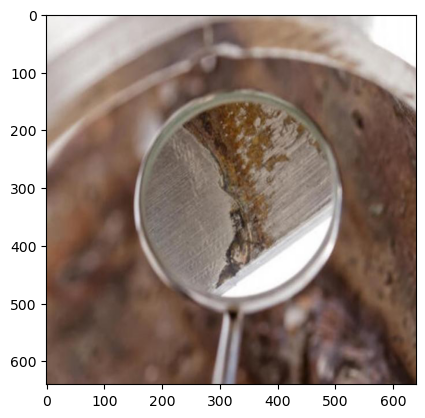

In [28]:
path_view = "valid/images/Screenshot-2022-12-05-231929_jpeg_jpg.rf.0f2a7b6941f6c0b4285f0385cd92f9b3.jpg"
img_view = Image.open(path_view)
plt.imshow(img_view)

#### Suspiciously similar images

Some images in the valid set are very similair to each other. In the first code snippet we see two images that are in the same set (validation). The following snippet shows 2 images that resemble an image in the train set.

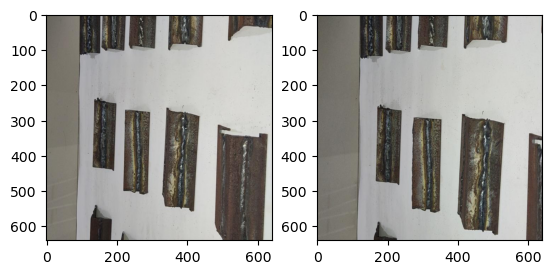

In [29]:
path_pre_list = ['valid/images/SampleV2_2_mp4-107_jpg.rf.6246eabc13b91626965a27f1f15e66da.jpg','valid/images/SampleV2_2_mp4-106_jpg.rf.377879e04f1e7209a3aa340ccfe1084b.jpg']
f, axarr = plt.subplots(1,2)
img_pre_list = []

for path in path_pre_list:
    img_pre_list.append(Image.open(path))

axarr[0].imshow(img_pre_list[0])
axarr[1].imshow(img_pre_list[1])

On a similair note, in the test set there are 2 images that are very similair to each other and an image in the training set (for the latter see first plot of this notebook).

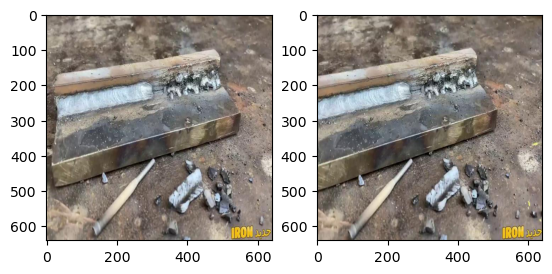

In [30]:
path_dup_example1 = "test/images/bad_weld_vid278_jpeg_jpg.rf.d7b37caf0f75a2942cae27dedf5c4c64.jpg"
img_dup_example1 = Image.open(path_dup_example1)

image_datas = []
image_datas.append(img_dup_example1)

path_dup_example2 = "test/images/bad_weld_vid277_jpeg_jpg.rf.0e6aafa2605c842edfaedaba06ded02c.jpg"
img_dup_example2 = Image.open(path_dup_example2)
image_datas.append(img_dup_example2)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_datas[0])
axarr[1].imshow(image_datas[1])

### How to differentiate classes

Good welding, bad welding or welding defects don't seem to show a specefic color. Although good welds seem to shine at a specific angle (see the left image in the following), a lack of a shine in the image isn't conclusive of a weld not being good. In other words, a weld doesn't need to shine in order to be good. Rather, a good weld seems to be related with a smooth and uniform texture (left side of the right image). Bad welds present opposite attributes of good welds. They are very uneven. No specific color differentiates the class. 

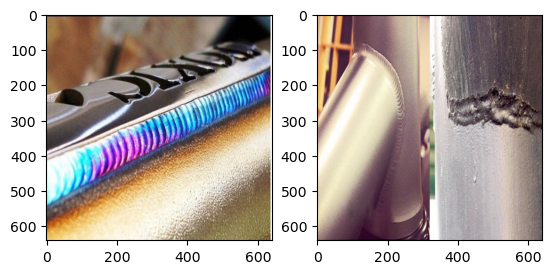

In [31]:
path_good_bad_list = ['train/images/good-tig-welds_8_jpeg_jpg.rf.a1d0d208c286afc59636e3cde9712b92.jpg','train/images/Good-Welding-images_10_jpeg_jpg.rf.01d5e76694c871526ebe4cfc9667ba5a.jpg']
f, axarr = plt.subplots(1,2)
img_good_bad_list = []

for path in path_good_bad_list:
    img_good_bad_list.append(Image.open(path))

axarr[0].imshow(img_good_bad_list[0])
axarr[1].imshow(img_good_bad_list[1])

### Key takeaways

Takeaway 1: What we can see is that there are some images that seem to be very similair, their angle are just slightly adjusted. This is probably because these images were captured while the camera was moving around the object. Since there aren't too many duplicates, we probably dont have to worry about overfitting. Nonetheless, we will keep this fact in mind and might take this up later.

Takeaway 2: The varying distance to the welding might pose problems when resizing the images since too little resoluton, i.e. 256x256 pixels, might pixelate the weld too much, giving the model difficulties in extracting meaningful information.

Takeaway 3: The texture is the most important attribute. Thus, we can grayscale. Thus, increasing the resolution wouldn't be as punishing.

Takeaway 4: A trend we see is that the weld isn't the main focus of the image, i.e. the camera isn't close to it. Thus, the weld can be quite small in relation to the picture. If the CNN has problems detecting the welds, we could try and restore the original resolution, zoom closer around the bounding box and re-run the pre-processing pipeline

### Structure of the labels

Each image is labelled. Each row in the corresponding text file indicates the class and the location of the weld (defect). 0 indicates 'Bad Weld', 1 'Good Weld' and 2 'Defect'. The numbers after the class are the bounding boxes.

In [32]:
file = open('train/labels/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.txt', 'r')
text = file.read()
print(text)

2 0.58515625 0.525 0.41796875 0.178125



# Pre-processing

As we could see in the previous chapter, some images have already been pre-processed. Lets get the filenames of the images that dont seem to be pre-processed based on the rules defined above, i.e. contains '-' but not 'jpeg'.

In [33]:
pre_processed_paths = []
non_processed_paths = []
for filename in os.listdir("train/images"):
    if "jpeg" not in filename and '-' in filename:
        pre_processed_paths.append(filename)
        continue
    else: 
        non_processed_paths.append(filename)

print("Amount of pre-proceseed images in training set : ",len(pre_processed_paths))
print("Amount of non-processed images in training set: ",len(non_processed_paths))

Amount of pre-proceseed images in training set :  620
Amount of non-processed images in training set:  219


To be exact, we will resize all images but not perform any other actions on pre-processed that have already been applied. But before resizing we need to blur the image to prevent aliasing.

!!!!After resizing, its possible to identify very visually aparent defects (right image). It gets more difficult for welds that are smaller. When zooming into the left image its difficult to recognize if any defects like cracks are in the weld. This underlines the hypothesis stated in Takeaway 2 from the EDA part. However, we will create the pipeline and train a model first to see if the model also has problems in identfying the issues. If it has difficulties, we will try and increase the resolution or zoom.  !!!!!

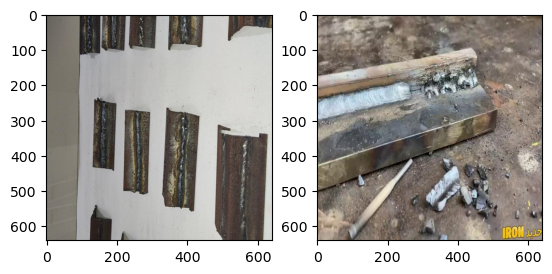

In [34]:
path_pre_list = ['valid/images/SampleV2_2_mp4-107_jpg.rf.6246eabc13b91626965a27f1f15e66da.jpg','test/images/bad_weld_vid277_jpeg_jpg.rf.0e6aafa2605c842edfaedaba06ded02c.jpg']
f, axarr = plt.subplots(1,2)
img_pre_list = []

for path in path_pre_list:
    img_pre_list.append(Image.open(path))

axarr[0].imshow(img_pre_list[0])
axarr[1].imshow(img_pre_list[1])

We will also apply grayscaling since good welding or welding defects don't seem to show a specefic color. Although good welds seem to shine at a specific angle (see the left image in the following), the shine isn't a unique attribute of a good weld. A good weld seems to be related with a smooth and uniform form (left side of the right image). Bad welds present opposite attributes of good welds. They are very uneven. No specific color differentiates the class, the shape and texture of the weld seem to be key. 

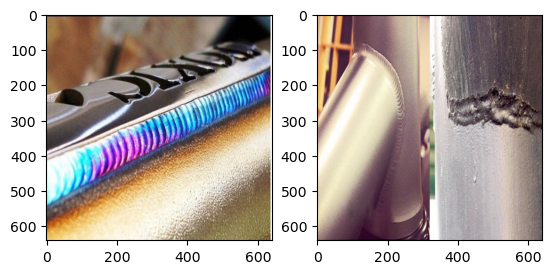

In [35]:
path_good_bad_list = ['train/images/good-tig-welds_8_jpeg_jpg.rf.a1d0d208c286afc59636e3cde9712b92.jpg','train/images/Good-Welding-images_10_jpeg_jpg.rf.01d5e76694c871526ebe4cfc9667ba5a.jpg']
f, axarr = plt.subplots(1,2)
img_good_bad_list = []

for path in path_good_bad_list:
    img_good_bad_list.append(Image.open(path))

axarr[0].imshow(img_good_bad_list[0])
axarr[1].imshow(img_good_bad_list[1])

Looking at the greyscale image again, we can confirm that the welds are still recongnizeable even without the full RGB spectrum

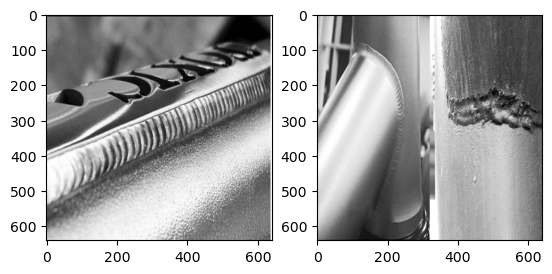

In [36]:
path_good_bad_list = ['train/images/good-tig-welds_8_jpeg_jpg.rf.a1d0d208c286afc59636e3cde9712b92.jpg','train/images/Good-Welding-images_10_jpeg_jpg.rf.01d5e76694c871526ebe4cfc9667ba5a.jpg']
f, axarr = plt.subplots(1,2)
img_good_bad_list = []

for path in path_good_bad_list:
    img_good_bad_list.append(image.load_img(path, color_mode='grayscale'))

axarr[0].imshow(img_good_bad_list[0],cmap = 'gray')
axarr[1].imshow(img_good_bad_list[1],cmap = 'gray')

#### Checking class balance

To set a baseline and get an idea of the model performance we should check the class balance

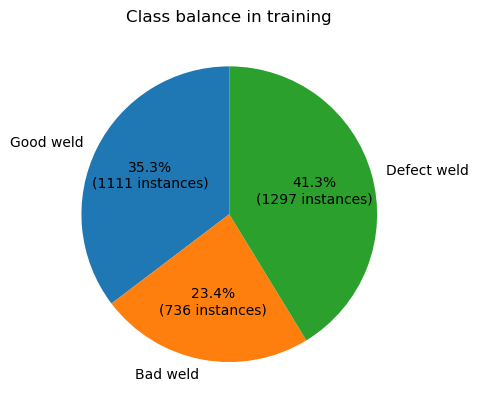

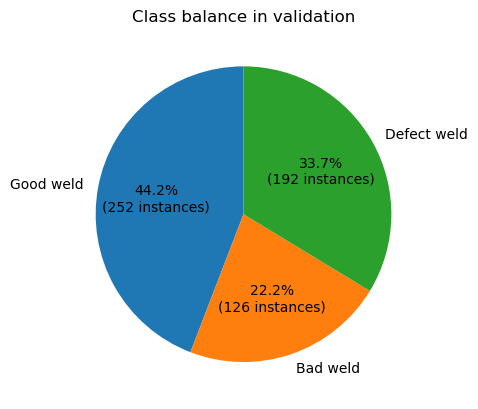

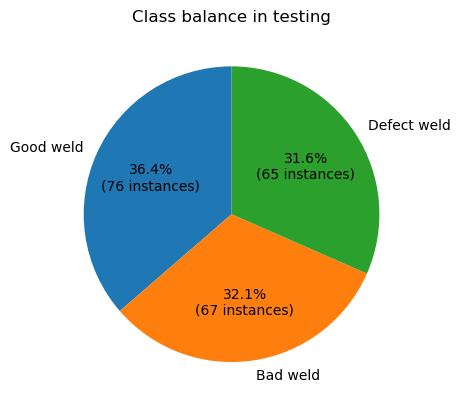

In [37]:
# Function from https://www.geeksforgeeks.org/plot-a-pie-chart-in-python-using-matplotlib/
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} instances)".format(pct, absolute)

#train set
num_good_train = 0
num_bad_train = 0
num_def_train = 0
for filename in os.listdir("train/labels"):
    path = "train/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_train+=1   
            if line == "1":
                num_good_train+=1
            if line == "2":
                num_def_train+=1

train_balance = np.array([num_good_train, num_bad_train, num_def_train])
mylabels = ["Good weld", "Bad weld", "Defect weld"]

plt.pie(train_balance, labels = mylabels, startangle = 90, autopct = lambda pct: func(pct, train_balance))
plt.title("Class balance in training")
plt.show()

# validation set
num_good_valid = 0
num_bad_valid = 0
num_def_valid = 0
for filename in os.listdir("valid/labels"):
    path = "valid/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_valid+=1   
            if line == "1":
                num_good_valid+=1
            if line == "2":
                num_def_valid+=1

valid_balance = np.array([num_good_valid, num_bad_valid, num_def_valid])

plt.pie(valid_balance, labels = mylabels, startangle = 90, autopct = lambda pct: func(pct, valid_balance))
plt.title("Class balance in validation")
plt.show()

# testing set
num_good_test = 0
num_bad_test = 0
num_def_test = 0
for filename in os.listdir("test/labels"):
    path = "test/labels/" + filename
    with open(path, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line[0]
            if line=="0":
                num_bad_test+=1   
            if line == "1":
                num_good_test+=1
            if line == "2":
                num_def_test+=1

test_balance = np.array([num_good_test, num_bad_test, num_def_test])

plt.pie(test_balance, labels = mylabels, startangle = 90, autopct = lambda pct: func(pct, test_balance))
plt.title("Class balance in testing")
plt.show()



We can see that the testing set is most uniformally balanced. However, in validation and in training defect and good weld are the most often. Bad weld only appear around 20% of the time. We will continue building the model but this should be kept in mind. Poor performance regarding bad weld could be due to this, so we should just keep this in mind

#### Formatting the data splits to be used by the model

Since we have multilabel data, our model should predict whether a good weld, bad weld and/or defect weld is present. Since they can all be present in one picture, we have 3 target classes, each of them being independent of each other since they can all occur at once. Thus, we need to format our data accordingly. 

First we will train a CNN without the use of bounding boxes

In [ ]:
from tqdm import tqdm
# Assisted by chatgpt
def load_images(split_path, size, color_mode):
    y = []
    x = []
    bounding_boxes = []
    for fname in tqdm(os.listdir((split_path+"images/"))):
        img_path = os.path.join(split_path+"images/",fname)

        # Load and resize image
        img = image.load_img(img_path, color_mode=color_mode) # , target_size=IMAGE_SIZE, color_mode=COLOR_MODE)

        # Convert to array
        img_array = image.img_to_array(img)  # shape: (H, W, C)

        if size != 640:
            blur = cv.blur(img_array,(5,5))
            img_array = cv.resize(blur, (size, size))

        # Normalize to [0,1]
        img_array /= 255.0

        x.append(img_array)

        path_label = split_path + "labels/" + img_path[13:-3] + "txt"
        with open(path_label, 'r') as file:
            # Read each line in the file
            classes = []
            bounding_box_string = []
            for line in file:
                classes.append(line[0])
                bounding_box_string.append(line[2:-1])
        
            y.append(classes)
            bounding_boxes.append(bounding_box_string)

    return [np.array(x, dtype=np.float32), y, bounding_boxes]

In [39]:
# train_x_gray_256 = load_images("train/", 256, 'grayscale')

ChatGPT:

In [40]:
IMAGE_SIZE = (256, 256)   # choose a consistent size
COLOR_MODE = 'grayscale'  # or 'rgb'



train_x_gray_256 = []
train_y = []
valid_x_gray_256 = []
valid_y = []
test_x_gray_256 = []
test_y = []
train_bounding_boxes = []


for fname in tqdm(os.listdir("train/images")):
    img_path = os.path.join("train/images", fname)

    # Load and resize image
    img = image.load_img(img_path, color_mode=COLOR_MODE) # , target_size=IMAGE_SIZE, color_mode=COLOR_MODE)

    # Convert to array
    img_array = image.img_to_array(img)  # shape: (H, W, C)

    blur = cv.blur(img_array,(5,5))
    resized_image = cv.resize(blur, (256, 256))

    # Normalize to [0,1]
    resized_image /= 255.0

    train_x_gray_256.append(resized_image)

    path_label = "train/labels/" + img_path[13:-3] + "txt"
    with open(path_label, 'r') as file:
        # Read each line in the file
        classes = []
        bounding_box_string = []
        for line in file:
            classes.append(line[0])
            bounding_box_string.append(line[2:-1])
    
        train_y.append(classes)
        train_bounding_boxes.append(bounding_box_string)

train_x_gray_256 = np.array(train_x_gray_256, dtype=np.float32)

for fname in tqdm(os.listdir("valid/images")):
    img_path = os.path.join("valid/images", fname)

    # # Load and resize image
    # img = image.load_img(img_path, target_size=IMAGE_SIZE, color_mode=COLOR_MODE)

    # # Convert to array
    # img_array = image.img_to_array(img)  # shape: (H, W, C)

    # # Normalize to [0,1]
    # img_array /= 255.0

    # valid_x_gray_256.append(img_array)

    # Load and resize image
    img = image.load_img(img_path, color_mode=COLOR_MODE) # , target_size=IMAGE_SIZE, color_mode=COLOR_MODE)

    # Convert to array
    img_array = image.img_to_array(img)  # shape: (H, W, C)

    blur = cv.blur(img_array,(5,5))
    resized_image = cv.resize(blur, (256, 256))

    # Normalize to [0,1]
    resized_image /= 255.0
    valid_x_gray_256.append(resized_image)
    
    path_label = "valid/labels/" + img_path[13:-3] + "txt"
    with open(path_label, 'r') as file:
        # Read each line in the file
        classes = []
        for line in file:
            classes.append(line[0])
        
        valid_y.append(classes)

valid_x_gray_256 = np.array(valid_x_gray_256, dtype=np.float32)

100%|██████████| 176/176 [00:00<00:00, 341.90it/s]


In [41]:
print("train_x_gray_256:", train_x_gray_256.shape, train_x_gray_256.dtype)  # (N, H, W, C), float32


train_x_gray_256: (839, 256, 256) float32


We have 839 images with a shape of 256x256 pixels. 3 represents the color channels

For each picture we now need an array for the labels, i.e. [x,y,z] where each element is binary and represents a different class in the image. So we have to format the train_y since currently it looks like this "['2', '2', '2', '2', '2', '0', '0', '0']"

In [73]:
def label_string_to_unique(label_array):
    binary_label_train_y = []
    for array in label_array:
        good = 0
        bad = 0
        defect = 0
        for element in array:
            if element == "0":
                bad = 1
            elif element == "1":
                good = 1
            else:
                defect = 1
        binary_label_train_y.append([bad,good,defect])

    return binary_label_train_y

In [42]:
binary_label_train_y = []
binary_label_valid_y = []
binary_label_test_y = []
for array in train_y:
    good = 0
    bad = 0
    defect = 0
    for element in array:
        if element == "0":
            bad = 1
        elif element == "1":
            good = 1
        else:
            defect = 1
    binary_label_train_y.append([bad,good,defect])

for array in valid_y:
    good = 0
    bad = 0
    defect = 0
    for element in array:
        if element == "0":
            bad = 1
        elif element == "1":
            good = 1
        else:
            defect = 1
    binary_label_valid_y.append([bad,good,defect])

for array in test_y:
    good = 0
    bad = 0
    defect = 0
    for element in array:
        if element == "0":
            bad = 1
        elif element == "1":
            good = 1
        else:
            defect = 1
    binary_label_test_y.append([bad,good,defect])




Lets validate our shape

In [43]:
binary_label_train_y = np.array(binary_label_train_y)
binary_label_valid_y = np.array(binary_label_valid_y)
binary_label_test_y = np.array(binary_label_test_y)
print(binary_label_train_y.shape)

(839, 3)


#### Setting the seed

In [44]:
from numpy.random import seed
import keras
from keras import layers
from keras import initializers

seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Training models

### Multilabel image classification

We will try out different models in this chapter. We will train 2 types of CNNs, one simple custom CNN and one advanced CNN (custom VGG-16).

#### First model architecture

We will build a very simple model first.

In [45]:
basic_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = ((256, 256, 1))),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dense(3,activation = "sigmoid")
])

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
basic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,240,195 (225.98 MB)

 Trainable params: 59,240,195 (225.98 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

In [48]:
#gpt
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_basic = basic_model.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=5,
    callbacks=[callback],
    verbose=1
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 642ms/step - accuracy: 0.2321 - loss: 0.7615 - val_accuracy: 0.0852 - val_loss: 0.6882
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 634ms/step - accuracy: 0.1508 - loss: 0.6507 - val_accuracy: 0.3580 - val_loss: 0.6530
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 632ms/step - accuracy: 0.2633 - loss: 0.5980 - val_accuracy: 0.3182 - val_loss: 0.6322
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step - accuracy: 0.3611 - loss: 0.4819 - val_accuracy: 0.2330 - val_loss: 0.8425
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 650ms/step - accuracy: 0.3776 - loss: 0.3665 - val_accuracy: 0.4545 - val_loss: 0.9327


#### Evaluation of simple model

We can see that training accuracy continously increases while the training loss decreases. Similairly, validation accuracy increase up to 37.5%. However, the loss function consistenly increases. A noticable lower validation accuracy shows that we are overfitting to the training data. This is also supported by the validation loss increasing majorly. Thus, in further models we have to counteract this. There are a few options. For one, we can add dropout layers which sets a random set of nodes in that layer to 0. Second, we can add Normalization layers. Third, we can further augment the data, especially since around 60% are lab generated and look similair.

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step

2025-05-10 19:38:12.999433: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-10 19:38:12.999718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Chance for bad: 0.6048907041549683
Chance for good: 0.49277710914611816
Chance for defect: 0.6295705437660217
Actual truth label: ['1']


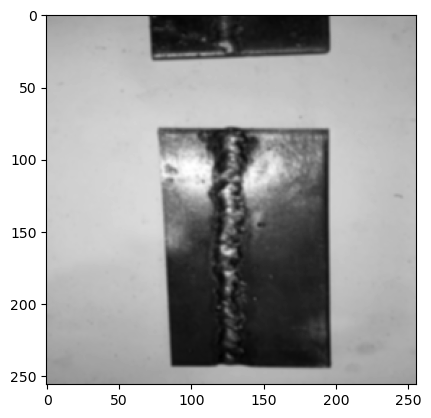

In [206]:
prob = basic_model.predict(valid_x_gray_256)[50]
label_structure = ["bad","good","defect"]
for i, chance in enumerate(prob):
    print(f"Chance for {label_structure[i]}: {chance}")

print(f"Actual truth label: {valid_y[50]}")
plt.imshow(valid_x_gray_256[50], cmap= 'gray')


#### Second model architecture

We are going to enhance the first CNN particularly by adding dropout layers

In [207]:
basic_model_dropout = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = ((256, 256, 1))),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation = "sigmoid")
])

In [208]:
basic_model_dropout.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,240,195 (225.98 MB)

 Trainable params: 59,240,195 (225.98 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
basic_model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

In [210]:
#gpt
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_dropout = basic_model_dropout.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=15,
    callbacks=[callback],
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.3061 - loss: 1.2321

2025-05-10 19:38:38.631657: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-10 19:38:38.631992: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 783ms/step - accuracy: 0.3044 - loss: 1.2196 - val_accuracy: 0.0739 - val_loss: 0.6871
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 738ms/step - accuracy: 0.1705 - loss: 0.6590 - val_accuracy: 0.0739 - val_loss: 0.6928
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 700ms/step - accuracy: 0.1433 - loss: 0.6497 - val_accuracy: 0.0739 - val_loss: 0.6936
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 739ms/step - accuracy: 0.1401 - loss: 0.6407 - val_accuracy: 0.0739 - val_loss: 0.6930


#### Third model architecture

For the second model we will base our model on the VGG-16 archtecture. VGG-16 was the best model in regards to the image classificaiton on ImageNet, a de facto standard on evaluating image processing models/architectures. Its important to note, that the original paper proposed an input layer of 224x224x3. Due to reasons mentioned in this paper (see EDA), we will try 256x256 pixels and 224x224. The latter resolution was proposed in the orignal VGG-16 paper but due to our targets not being very big in the image, we will increase the resolution. In addition, we will have grayscale instead of rgb images.

Possible disadvantges: Specialised for the ILSVRC dataset. So number of filters might be too large since that dataset contains 1000 classes, ours only 3.

original VGG

In [ ]:
# Using information found in https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
vgg_original = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = ((256, 256, 1))) ,
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation = "relu"), 
    tf.keras.layers.Conv2D(256,(3,3),activation = "relu"),
    tf.keras.layers.Conv2D(256,(3,3),activation = "relu"),   
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"), 
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"), 
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(4096,activation="relu"),      
    tf.keras.layers.Dense(4096,activation ="relu"),
    tf.keras.layers.Dense(3,activation = "sigmoid")  
])

In [ ]:
vgg_original.summary()

In [ ]:
vgg_original.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#gpt
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = vgg_original.fit(
    train_x_gray_256, binary_label_train_y,
    validation_data=(valid_x_gray_256, binary_label_valid_y),
    batch_size=32,
    epochs=1, # TODO: More epochs
    callbacks=[callback],
    verbose=1
)


Takes long to learn and has poor accuracy and loss in training and validation. So a bigger model might not be better in detecting the right classes

### Object Detection using bounding boxes

Above we trained classicial CNNs to detect the classes in our images. They don't perform overly well. Maybe we can fix this using bounding boxes. We will train the following architectures: RetinaNet and YoloV8

Vision Transformer, Mask R-CNN and Faster R-CNN are  sadly not in keras package and are thus not trained

#### Importing Faster R-CNN using resnet as CNN

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.model_download("tensorflow/faster-rcnn-inception-resnet-v2/tensorFlow2/640x640")

In [211]:
f_rcnn = tf.saved_model.load(".")

In [ ]:
!git clone https://github.com/tensorflow/models.git


In [227]:
f_rcnn("train/images/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.jpg")

TypeError: Binding inputs to tf.function failed due to `Cannot convert 'train/images/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.jpg' to EagerTensor of dtype uint8`. Received args: ('train/images/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.jpg',) and kwargs: {} for signature: (input_tensor: TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name=None)).

#### YoloV8 without weights

In [ ]:
# !pip install ultralytics
# conda install pytorch
# conda install torchvision

In [30]:
from ultralytics import YOLO
# Also install pytorch, torchvision

model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 52.3MB/s]


In [ ]:
# From https://www.kaggle.com/code/mohammedmohsen0404/welding-defect-object-detection-using-yolov8#Evaluate-the-model
model.train(data='data.yaml', epochs=30, imgsz=640, batch=16, device="mps")
            
            # , name='welding_v2_aug',
            #    lr0=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
            #    box=0.05, cls=0.5, iou=0.2, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=1.0, mixup=0.5)


# name='welding_v2_aug',

New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.130 🚀 Python-3.9.18 torch-2.3.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

train: Scanning /Users/emilschallwig/Documents/AI applications/Manufacturing/archive/The Welding Defect Dataset/The Welding Defect Dataset/train/labels.cache... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 308.5±113.5 MB/s, size: 79.1 KB)



val: Scanning /Users/emilschallwig/Documents/AI applications/Manufacturing/archive/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]

Plotting labels to runs/detect/train14/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train14
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.804      2.599       1.53         30        640: 100%|██████████| 53/53 [10:50<00:00, 12.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]

                   all        176        573      0.606      0.162      0.199     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/30         0G      1.862      2.575      1.573         31        640: 100%|██████████| 53/53 [27:35<00:00, 31.24s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.03s/it]

                   all        176        573      0.274      0.237      0.151     0.0636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/30         0G      1.882      2.523      1.565         34        640: 100%|██████████| 53/53 [25:35<00:00, 28.97s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.11s/it]

                   all        176        573      0.529      0.213      0.172     0.0775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/30         0G      1.877      2.447      1.603         34        640: 100%|██████████| 53/53 [24:38<00:00, 27.89s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.01s/it]

                   all        176        573      0.193      0.294      0.173      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/30         0G      1.837      2.349      1.568         42        640: 100%|██████████| 53/53 [42:17<00:00, 47.87s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.06s/it]

                   all        176        573      0.353        0.3      0.255      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/30         0G      1.792      2.267      1.522         28        640: 100%|██████████| 53/53 [1:10:20<00:00, 79.63s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]

                   all        176        573      0.612      0.275      0.266      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/30         0G      1.763      2.201      1.512         72        640: 100%|██████████| 53/53 [1:32:23<00:00, 104.59s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.60s/it]

                   all        176        573      0.625      0.341      0.295      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/30         0G      1.761      2.174      1.524         45        640: 100%|██████████| 53/53 [21:18<00:00, 24.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.66s/it]

                   all        176        573      0.444      0.398      0.333      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.706       2.09       1.48         39        640: 100%|██████████| 53/53 [22:15<00:00, 25.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.73s/it]

                   all        176        573      0.483      0.469      0.371      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/30         0G      1.717      2.067      1.479         53        640: 100%|██████████| 53/53 [31:17<00:00, 35.42s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.27s/it]

                   all        176        573      0.351      0.468      0.338      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/30         0G      1.664      2.035      1.451         25        640: 100%|██████████| 53/53 [23:24<00:00, 26.50s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [02:28<00:00, 24.77s/it]

                   all        176        573      0.445      0.385       0.32      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/30         0G      1.643       1.97      1.458         30        640: 100%|██████████| 53/53 [10:31<00:00, 11.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.01s/it]

                   all        176        573      0.573      0.414      0.355       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/30         0G      1.636      1.929      1.452         52        640: 100%|██████████| 53/53 [39:38<00:00, 44.88s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.34s/it]

                   all        176        573      0.415      0.457      0.396      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/30         0G      1.626      1.912      1.442         20        640: 100%|██████████| 53/53 [13:31<00:00, 15.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.19s/it]

                   all        176        573      0.568      0.384      0.362      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/30         0G      1.572      1.847      1.388         36        640: 100%|██████████| 53/53 [20:09<00:00, 22.82s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.19s/it]

                   all        176        573      0.613       0.44      0.439      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/30         0G      1.572      1.804      1.402         55        640: 100%|██████████| 53/53 [12:29<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.79s/it]

                   all        176        573      0.575      0.453      0.476       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/30         0G       1.59      1.799      1.398         88        640:  77%|███████▋  | 41/53 [44:11<1:59:07, 595.64s/it]

# Further data augmentation/processing

Let us further augment our images. We will adjust the contrast and flip the images. Each augmentation will be saved as a new image. By enhancing the number of images in our training data we can hopefully gain higher accuracies while maintaining low loss values. We will apply this on the "non-preprocessed data" because the "processed" data already has been augmentated in similair ways (see EDA).

In [89]:
# copied from https://stackoverflow.com/questions/71960632/how-to-rotate-a-rectangle-bounding-box-together-with-an-image
def rotate90Deg(bndbox, img_dim): # just passing width of image is enough for 90 degree rotation.
   x_min,y_min,x_max,y_max = bndbox
   new_xmin = y_min
   new_ymin = img_dim-x_max
   new_xmax = y_max
   new_ymax = img_dim-x_min
   return [new_xmin, new_ymin,new_xmax,new_ymax]

# Advanced through ChatGPT
def rotate180Deg(bndbox, img_dim):
    x_min, y_min, x_max, y_max = bndbox
    new_xmin = img_dim - x_max
    new_ymin = img_dim - y_max
    new_xmax = img_dim - x_min
    new_ymax = img_dim - y_min
    return [new_xmin, new_ymin, new_xmax, new_ymax]

def rotate270Deg(bndbox, img_dim):  # Only height needed, similar to how 90° uses width
    x_min, y_min, x_max, y_max = bndbox
    new_xmin = img_dim - y_max
    new_ymin = x_min
    new_xmax = img_dim - y_min
    new_ymax = x_max
    return [new_xmin, new_ymin, new_xmax, new_ymax]

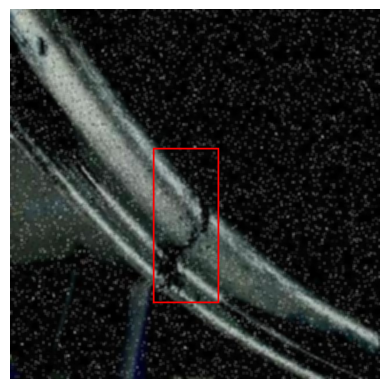

In [ ]:
from PIL import ImageDraw

def rotate_image_and_label(label_coord_array, image_array, degree):
    rotated_image_array = []
    rotated_coord_image = []
    for i, labels_image in enumerate(label_coord_array):
        rotated_coord_label = []
        for coord_label in labels_image:
            
            original_image = Image.fromarray(image_array[i])
            x1, y1, x2, y2 = coord_label
            size = original_image.size
            
            

            if degree==90:
                x1_new, y1_new, x2_new, y2_new = rotate90Deg([x1, y1, x2, y2], size)
                rotated_image = original_image.rotate(90)
            if degree==180:
                x1_new, y1_new, x2_new, y2_new = rotate180Deg([x1, y1, x2, y2], size)
                rotated_image = original_image.rotate(180)
            if degree==270:
                x1_new, y1_new, x2_new, y2_new = rotate270Deg([x1, y1, x2, y2], size)
                rotated_image = original_image.rotate(270)

            rot_img_array = image.as_array(rotated_image)
            
            rotated_coord_label.append([x1_new, y1_new, x2_new, y2_new])

        # img_array = image.img_to_array(img)
        
        rotated_image_array.append(rotated_image)
        rotated_coord_image.append(rotated_coord_label)


# Load original image
image_path = "train/images/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.jpg"
label_path = "train/labels/0e538f39-1d30436c-c23_jpg.rf.3ce38b0e86b3cd83db06acc794de04f0.txt"

original_image = Image.open(image_path)

# Rotate the image by 90 degrees
rotated_image = original_image.rotate(90)
rotated_image2 = original_image.rotate(270)

# Prepare for drawing
draw = ImageDraw.Draw(rotated_image2)

# Image dimensions (YOLO boxes are normalized to these)
img_width, img_height = rotated_image.size

# Read and parse the YOLO bounding box
with open(label_path, 'r') as file:
    for line in file:
        bbox = line.strip().split(' ')[1:]  # skip class id, get bbox only
        x_center, y_center, width, height = map(float, bbox)

        # Denormalize
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Convert to top-left and bottom-right
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        # x1, y1, x2, y2 = rotate90Deg([x1, y1, x2, y2], 640)
        x3, y3, x4, y4 = rotate270Deg([x1, y1, x2, y2], 640)

        # Draw bounding box
        # draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.rectangle([x3, y3, x4, y4], outline="red", width=3)

# Show the rotated image with bounding box
plt.imshow(rotated_image2)
plt.axis('off')
plt.show()


In [105]:
def bbox_to_coord(bbox):
    array_image = []
    for img_arr in bbox:
        array_class = []
        for class_instance in img_arr:
            print(class_instance)
            bbox = class_instance.strip().split(' ')  # skip class id, get bbox only
            print(bbox)
            x_center, y_center, width, height = map(float, bbox)

            # Denormalize
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Convert to top-left and bottom-right
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            array_class.append([x1,y1,x2,y2])

        array_image.append(array_class)

    return array_image
        

In [141]:
train_bounding_boxes_coordinates = bbox_to_coord(train_bounding_boxes)
train_bounding_boxes_coordinates

0.646875 0.7453125 0.1578125 0.090625
['0.646875', '0.7453125', '0.1578125', '0.090625']
0.61640625 0.8953125 0.1734375 0.1234375
['0.61640625', '0.8953125', '0.1734375', '0.1234375']
0.7078125 0.1296875 0.10546875 0.19453125
['0.7078125', '0.1296875', '0.10546875', '0.19453125']
0.88046875 0.67265625 0.13984375 0.1328125
['0.88046875', '0.67265625', '0.13984375', '0.1328125']
0.1015625 0.21875 0.0859375 0.1046875
['0.1015625', '0.21875', '0.0859375', '0.1046875']
0.2546875 0.1421875 0.04453125 0.1171875
['0.2546875', '0.1421875', '0.04453125', '0.1171875']
0.046875 0.7234375 0.09140625 0.07421875
['0.046875', '0.7234375', '0.09140625', '0.07421875']
0.70078125 0.14765625 0.3359375 0.121875
['0.70078125', '0.14765625', '0.3359375', '0.121875']
0.134375 0.1984375 0.2609375 0.1125
['0.134375', '0.1984375', '0.2609375', '0.1125']
0.69296875 0.7109375 0.4921875 0.17109375
['0.69296875', '0.7109375', '0.4921875', '0.17109375']
0.38203125 0.5296875 0.0375 0.56171875
['0.38203125', '0.5296875

[[[363.5, 448.0, 464.5, 506.0], [339.0, 533.5, 450.0, 612.5]],
 [[419.25, 20.75, 486.75, 145.25],
  [518.75, 388.0, 608.25, 473.0],
  [37.5, 106.5, 92.5, 173.5],
  [148.75, 53.5, 177.25, 128.5],
  [0.75, 439.25, 59.25, 486.75],
  [341.0, 55.5, 556.0, 133.5],
  [2.5, 91.0, 169.5, 163.0],
  [286.0, 400.25, 601.0, 509.75]],
 [[232.5, 159.25, 256.5, 518.75],
  [109.75, 141.25, 128.25, 424.75],
  [231.5, 154.25, 257.5, 524.75],
  [427.5, 105.75, 470.5, 631.25]],
 [[0.0, 107.5, 146.0, 189.5],
  [404.25, 103.5, 506.75, 200.5],
  [277.0, 106.5, 352.0, 202.5],
  [484.75, 488.75, 602.25, 625.25],
  [270.75, 120.5, 508.25, 185.5],
  [228.25, 500.75, 600.75, 619.25]],
 [[76.25, 297.0, 614.75, 400.0]],
 [[46.5, 139.5, 67.5, 371.5],
  [143.0, 124.5, 167.0, 435.5],
  [276.75, 51.25, 319.25, 473.75],
  [546.5, 57.25, 598.5, 637.75]],
 [[0.25, 196.0, 80.75, 245.0],
  [451.0, 190.75, 640.0, 227.25],
  [0.0, 204.0, 217.0, 238.0],
  [424.0, 451.75, 640.0, 479.25],
  [0.25, 460.75, 234.75, 484.25]],
 [[392

Let us also try and train on the lab data only. Since the number of images are limited but around 40% are highly diverse, it may be very difficult for a model to learn accuracetly given the author's limited computational resources. To do this, we will filter for paths that start with "SampleV" into our data. Images following this naming condition resemble lab conditions. In addition, we will increase the resolution of the picture 

"SampleV2_1_mp4-78_jpg.rf.ad3a417c88d00b1be1901f3b8ffbd60d"

In [49]:
basic_model_natural = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = ((640, 640, 3))),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dense(3,activation = "sigmoid")
])

/opt/anaconda3/envs/manufacturing/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
basic_model_natural.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
train_natural_x, train_natural_y, bboxes_train = load_images("train/", 640, "rgb")
valid_natural_x, valid_natural_y, bboxes_valid = load_images("valid/", 640, "rgb")

100%|██████████| 176/176 [00:00<00:00, 321.18it/s]


In [66]:

train_x_gray_256.shape

(839, 256, 256)

In [72]:
#gpt
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_dropout = basic_model_natural.fit(
    train_natural_x, binary_label_train_y,
    validation_data=(valid_natural_x, binary_label_valid_y),
    batch_size=32,
    epochs=15,
    callbacks=[callback],
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 0.2390 - loss: 2.4346 - val_accuracy: 0.4034 - val_loss: 0.6533
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 224s 8s/step - accuracy: 0.2962 - loss: 0.5787 - val_accuracy: 0.2557 - val_loss: 0.6436
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 219s 8s/step - accuracy: 0.3965 - loss: 0.4308 - val_accuracy: 0.3920 - val_loss: 0.6823
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 375s 14s/step - accuracy: 0.5824 - loss: 0.2634 - val_accuracy: 0.4716 - val_loss: 0.9795
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 211s 8s/step - accuracy: 0.6810 - loss: 0.1468 - val_accuracy: 0.4318 - val_loss: 1.3230
